# Prueba de Red Neuronal Artificial con Back Propagation

Para esta prueba utilizo un dataset generado por un script (generar-dataset.sh), en el que se simula a un usuario en un monoambiente, con hábitos muy marcados: De 23hs a 7:00hs duerme. De 7:00 a 7:30 se prepara para salir. De 7:30 a 18:30hs, los días de la semana está fuera del ambiente. Durante el fin de semana está presente. De 18:30hs a 19:30hs hay actividad variada (puede haber distintos niveles de sonido, puede o no estár prendida la luz, etc.). De 19:30 a 23hs hay actividad y la luz está prendida.

La idea es crear una red neuronal artifial que de como resultado el estado esperado del dispositivo de luz: Prendido/Apagado. Esta RNA debería además corregir los pesos de las funciones a medida que se entrena.


**IMPORTANTE:** Quiza el sensor de luminosidad debería tener el valor opuesto, ya que uno espera que la luz se prenda cuando HAY actividad y hay un nivel de luz muy bajo. Al mismo tiempo, si hay un nivel de luminosidad ALTO, el sistema no puede sacar como conclusión que hay que apagar la luz, porque entraríamos en un loop.

### Formato de los datos
Los datos creados por el script generar-dataset.sh están en el siguiente formato:


| Nombre | Tipo | Descripción | Ej. Valor |
|--------|------|---------|-------------|---------|
| **mes** | tinyint | Número de mes | 1 a 12 |
| **diaSemana** | tinyint | Número de día de la semana (Lunes 1, etc.) | 1 a 7 |
| **minuto** | tinyint | Minuto del dia| 0 a 1439 |
| **idSensor** | smallint | Identificador unico del sensor | 10123 |
| **sensCorriente** | smallint | Medición de corriente del dispositivo Lux asociado en miliamperes | 230 |
| **sensLuminosidad** | smallint | Medición del sensor de luminosidad, donde 0 = oscuro, 1 = muy iluminado | 0.871 |
| **sensSonido ** | smallint | Medición del sensor de sonido, donde 0 = silencio, 1 = alto nivel de sonoridad | 0.232 |
| **sensPresencia** | smallint | Medición del sensor de presencia, donde 0 = sin movimientos, 1 = hay movimientos | 0.856 |
| **estadoLuz** | tinyint | Indicador de estado del dispositivo Lux, donde 0 = apagado y 1 = encendido | 1 |

**IMPORTANTE:** Esta versión usa un valor decimar para el sensor de presencial. En una versión posterior lo hacemos con valor entero.

### Cargo algunas librerías necesarias

Librerías usadas durante este ejercicio:
* Pandas: para manipulación de grandes volúmenes de datos, en este caso importando de un csv a un array
* Matplot: Para hacer gráficos en 2D
* Numpy: Para computación científica y funciones matemáticas en general.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Además, más abajo voy a estar usando Scikit Learn: Un módulo que provée algoritmos de evaluación, entrenamiento y machine learning en general.

Esta línea es para que los gráficos se impriman dentro de Jupyter Notebook

In [15]:
%matplotlib inline

### Dataset
Cargo el dataset (previamente creado) y examino sus propiedades

In [16]:
df = pd.read_csv("./dataset.txt")
df.shape

(129601, 9)

El dataset tiene 129601 registros de 9 campos. La cantidad de registros está dada por 1 encabezado + 1 reg/min x 60 min x 24 horas x 90 días. Las columnas son las que se definen más arriba, y están organizadas de esta forma:

In [17]:
df.head()

,mes,diaSemana,minuto,idSensor,sensCorriente,sensLuminosidad,sensSonido,sensPir,estadoLuz
0,1,7,1,1020,0,0.027,0.065,0,0
1,1,7,2,1020,0,0.020,0.046,0,0
2,1,7,3,1020,0,0.026,0.051,0,0
3,1,7,4,1020,0,0.027,0.065,0,0
4,1,7,5,1020,0,0.023,0.074,0,0


In [18]:
df.tail()

,mes,diaSemana,minuto,idSensor,sensCorriente,sensLuminosidad,sensSonido,sensPir,estadoLuz
129596,3,5,1437,1020,0,0.817,0.102,1,0
129597,3,5,1438,1020,0,0.817,0.102,1,0
129598,4,6,1439,1020,0,0.817,0.119,1,0
129599,4,6,0,1020,0,0.022,0.082,0,0
129600,4,6,1,1020,0,0.020,0.047,0,0


### Chequeo de valores null, no debería haber
Dado que el dataset se creó manualmente, todos los datos fueron completados. En la práctica, algunos valores pueden faltar ya que no todos los sensores se instalan exactamente al mismo tiempo.

In [19]:
df.isnull().values.any()

False

### Función de correlación
Hace una matriz de correlación entre las variables. Cuanto más claro el color, mayor correlación entre las variables. La diagonal debería ser amarilla, y representa la correlación de una variable con sí misma.

Esta función tiene dos entradas:
1. El dataframe panda a analizar
2. El tamáño de gráfico que se quiere imprimir

In [20]:
def plot_corr(df, size=14):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

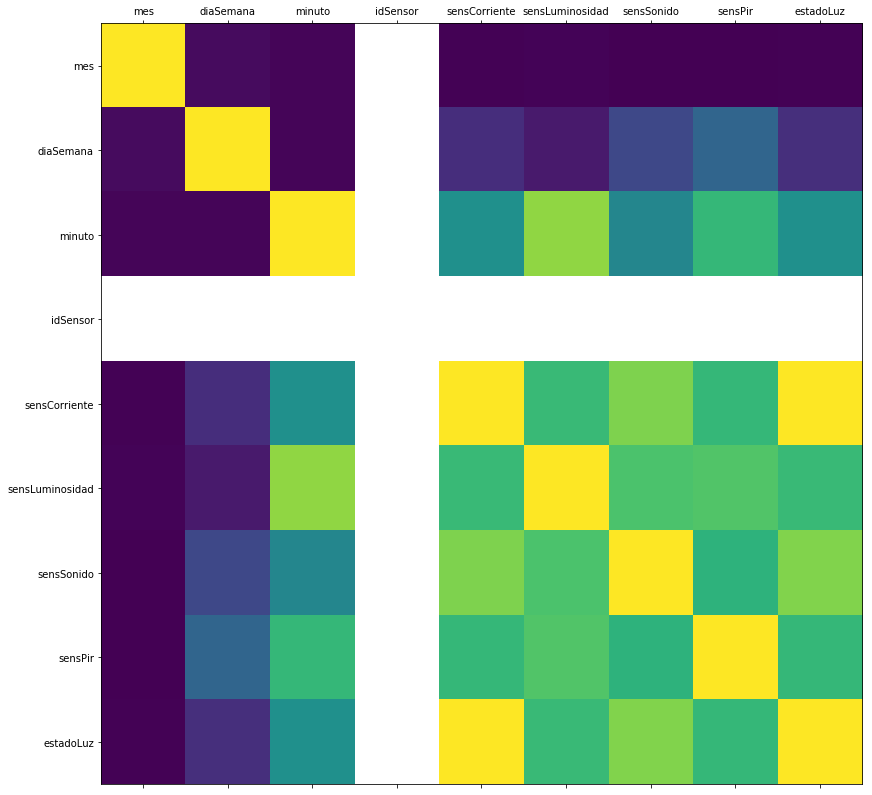

In [21]:
plot_corr(df)

In [22]:
df.corr()

,mes,diaSemana,minuto,idSensor,sensCorriente,sensLuminosidad,sensSonido,sensPir,estadoLuz
mes,1.000000,0.013472,-0.000032,NaN,-0.011129,-0.006920,-0.015481,-0.011975,-0.011025
diaSemana,0.013472,1.000000,-0.000013,NaN,0.119377,0.058457,0.202701,0.315808,0.119537
minuto,-0.000032,-0.000013,1.000000,NaN,0.493040,0.830640,0.452213,0.661991,0.493866
idSensor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensCorriente,-0.011129,0.119377,0.493040,NaN,1.000000,0.672746,0.804190,0.660163,0.998233
sensLuminosidad,-0.006920,0.058457,0.830640,NaN,0.672746,1.000000,0.711005,0.726260,0.673931
sensSonido,-0.015481,0.202701,0.452213,NaN,0.804190,0.711005,1.000000,0.641660,0.805654
sensPir,-0.011975,0.315808,0.661991,NaN,0.660163,0.726260,0.641660,1.000000,0.661332
estadoLuz,-0.011025,0.119537,0.493866,NaN,0.998233,0.673931,0.805654,0.661332,1.000000


La columna idSensor no provee información que sirva a la red neuronal, es solo un valor constante. Por otro lado, el sensor de corriente provee un valor que va a estar relacionado casi 1 a 1 con estadoLuz, ya que es lo que queremos averiguar, así que puedo eliminar ambas columnas. También veo que el mes no tiene correlación con ninguna otra columna, así que la borro.

In [23]:
del df['idSensor']
del df['sensCorriente']
del df['mes']

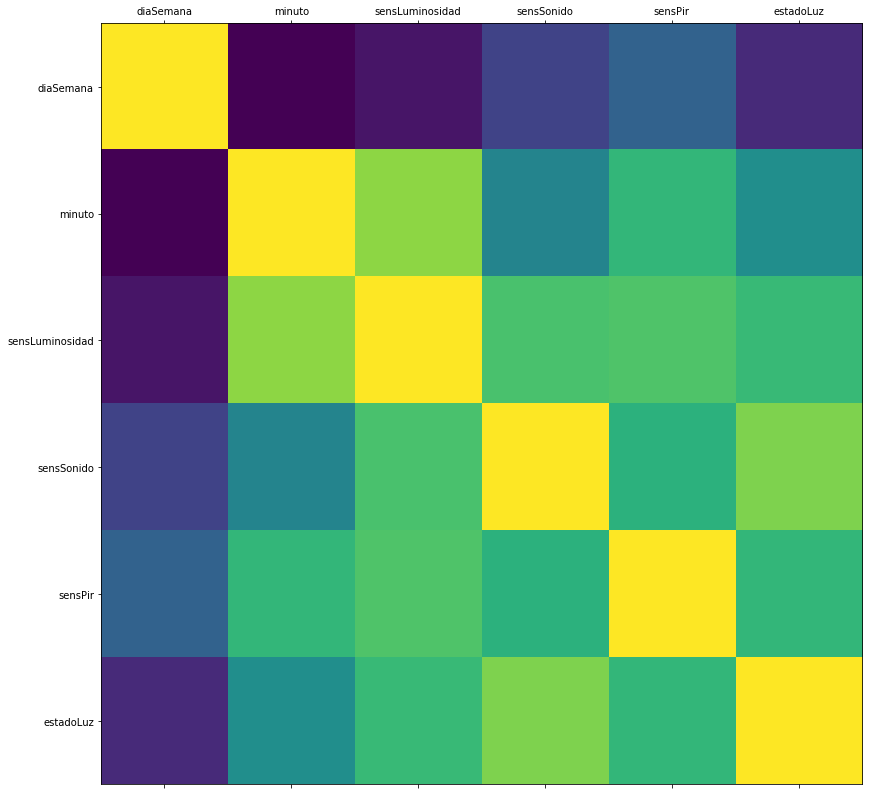

In [24]:
plot_corr(df)

De esta nueva versión del gráfico puedo sacar algunas conclusiones a simple vista:
1. No existe una correlación 1 a 1 entre ningún par de variables (lo que es bueno)
2. No exite correlación entre "mes" y "diaSemana" (lo que tiene sentido)
3. Existe cierta correlación entre los sensores con la hora o el día.
4. Existe una mayor correlación (colores más claros) entre los distintos sensores entre sí

Entonces, parece que los datos en el dataset creado a mano tienen el sentido que se le quiso dar. Lo realmente interesante va a ser obtener estos datos del mundo real y ver que relaciones surgen.



### Chequeo de distribución de clases
Debería haber dos clases, la clase en la que el dispositivo esa prendido (estadoLuz = 1) y la clase en la que está apagado.

In [25]:
num_obs = len(df)
num_true = len(df.loc[df['estadoLuz'] == 1])
num_false = len(df.loc[df['estadoLuz'] == 0])
print("Número de casos verdaderos:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Número de casos falsos: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Número de casos verdaderos:  28587 (22.06%)
Número de casos falsos: 101014 (77.94%)


Esta distribución está un poquito desbalanceada, dado que el usuario está la mayor parte del día fuera de la oficina, y durante la noche durmiendo. Son pocas las horas de Lunes a Viernes en que está activo. Durante el fin de semana la cantidad de horas aumenta. Por ahí 60-40 hubiera estado mejor, ya que tendría más casos verdaderos para analizar. Vamos a ver como sale.

### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba. Para esto voy a usar del módulo scikit-learn la función train_test_split.

Los conjuntos de datos van a llamarse:
* X_train: Datos de entrenamiento. Las 7 columnas con los valores del mes, día, sensores, etc, compuesto por el 70% de los registros
* y_train: Resultado de entrenamiento. Columna *estadoLuz* para el 70% de los registros
* X_test: Datos para hacer la validación. Tienen el mismo formato que X_train, pero corresponden al 30% del conjunto de datos
* y_test: Resultados para validar la performance del algoritmo aplicado a X_test

O puesto de otro modo:

| Entrada (5 columnas) | Salida (1 columna)| 
|-------------|--------|
| X_train (70%) | y_train|
| X_test (30%)| y_test |

In [26]:
from sklearn.model_selection import train_test_split

feature_col_names = ['diaSemana', 'minuto', 'sensLuminosidad', 'sensSonido', 'sensPir']
predicted_class_names = ['estadoLuz']

X = df[feature_col_names].values     # Columnas del predictor (5 X m)
y = df[predicted_class_names].values # Clase predecida (1=verdadero, 0=falso) column (1 X m)
split_test_size = 0.30               # 0.30 es 30%, el tamaño para pruebas

# 42 es una respuesta común
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)

Verifico que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [27]:
print("{0:0.2f}% en el set de entrenamiento".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% en el set de prueba".format((len(X_test)/len(df.index)) * 100))

70.00% en el set de entrenamiento
30.00% en el set de prueba


Verifico que la proporción de casos verdaderos y falsos se mantenga en los conjuntos de entrenamiento y test:

In [28]:
print("Verdaderos en el total     : {0} ({1:0.2f}%)".format(len(df.loc[df['estadoLuz'] == 1]), (len(df.loc[df['estadoLuz'] == 1])/len(df.index)) * 100.0))
print("Falsos en el total         : {0} ({1:0.2f}%)".format(len(df.loc[df['estadoLuz'] == 0]), (len(df.loc[df['estadoLuz'] == 0])/len(df.index)) * 100.0))
print("")
print("Verdaderos en entrenamiento: {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
print("Falsos en entrenamiento    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
print("")
print("Verdaderos en test         : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
print("Falsos en test             : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

Verdaderos en el total     : 28587 (22.06%)
Falsos en el total         : 101014 (77.94%)

Verdaderos en entrenamiento: 19979 (22.02%)
Falsos en entrenamiento    : 70741 (77.98%)

Verdaderos en test         : 8608 (22.14%)
Falsos en test             : 30273 (77.86%)


El resultado está muy bien, la proporción se mantiene lo más cerca posible.


## Entrenamiento inicial
Para este entrenamiento voy a usar otro módulo de scikit-learn: neural_network. 

A diferencia del ejemplo del algoritmo de clasificación, en este caso voy a usar el algoritmo MLPRegression. Implementa un perceptrón multi capa (MLP) que se entrena usando backpropagation, pero no tiene función de activación.

Más información aquí:
http://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression

In [32]:
from sklearn.neural_network import MLPRegressor
reg_model = MLPRegressor(random_state=1)
reg_model.fit(X_train, y_train.ravel())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Performance usando los datos de entrenamiento
Para esto voy a importar la función metrics.

In [73]:
from sklearn import metrics
reg_predict_train = reg_model.predict(X_train)

print("Error medio absoluto: {0:.4f}".format(metrics.explained_variance_score(y_train, reg_predict_train)))
print("Promedio de error absoluto: {0:.4f}".format(metrics.mean_absolute_error(y_train, reg_predict_train)))
print("Promedio de error cuadrado: {0:.4f}".format(metrics.mean_squared_error(y_train, reg_predict_train)))
print("Media de error absoluto: {0:.4f}".format(metrics.median_absolute_error(y_train, reg_predict_train)))
print()

Error medio absoluto: 0.5336
Promedio de error absoluto: 0.2896
Promedio de error cuadrado: 0.1554
Media de error absoluto: 0.1987



### Performance usando los datos de prueba

In [74]:
reg_predict_test = reg_model.predict(X_test)

print("Error medio absoluto: {0:.4f}".format(metrics.explained_variance_score(y_test, reg_predict_test)))
print("Promedio de error absoluto: {0:.4f}".format(metrics.mean_absolute_error(y_test, reg_predict_test)))
print("Promedio de error cuadrado: {0:.4f}".format(metrics.mean_squared_error(y_test, reg_predict_test)))
print("Media de error absoluto: {0:.4f}".format(metrics.median_absolute_error(y_test, reg_predict_test)))
print()

Error medio absoluto: 0.5358
Promedio de error absoluto: 0.2885
Promedio de error cuadrado: 0.1547
Media de error absoluto: 0.1981



## Verificación final
¿Qué pasaría si tengo una nueva entrada en el dataset, que representa un comportamiento del usuario registrado en un momento en particular?

Por ejemplo, si digo "El Martes a las 2:16am ladro un perro mientras el usuario dormia", se podría traducir en un registro como:

| diaSemana | minuto | sensLuminosidad | sensSonido | sensPir |
|-|
| 2 | 136 | 0.020 | 0.400 | 1 |

Uno esperaría que a pesar de la detección de sonido y de presencia (el usuario se mueve), la luz debería estar apagada de todos modos. Veamos que resultado muestra el modelo.

In [54]:
X_new_test = [[2, 136, 0.02, 0.04, 1]]
reg_predict_new_test = reg_model.predict(X_new_test)

print ("Resultado: ", reg_predict_new_test)

Resultado:  [ 0.117097]


Por otro lado, si el evento ocurriera a las 18:30, con un nivel más alto de luminosidad y sonido:

In [66]:
X_new_test = [[2, 1110, 0.8, 0.7, 1]]
reg_predict_new_test = reg_model.predict(X_new_test)

print ("Resultado: ", reg_predict_new_test)

Resultado:  [ 0.92230051]


El resultado es el esperado. Como dije al principio, quizá el sensor de luminosidad está demasiado relacionado con el resultado, es algo para ver. De todos modos, este modelo parece algo que podemos aplicar, extendiendolo a más de un dispositivo por ambiente.

Lo otro que podemos hacer es usar la salida de esta red como entrada para una red general, que represente la casa.